In [8]:
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool, PythonAstREPLTool
import pandas as pd
import statsmodels as sm

df = pd.read_csv("HOUST.csv")
python_repl_tool = PythonAstREPLTool(locals={"df": df})

In [9]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            ( "system", system_prompt, ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [10]:
import functools

system_prompt = """You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
                It is important to understand the attributes of the dataframe before working with it. This is the result of running `df.head().to_markdown()`

                <df>
                {dhead}
                </df>

                You are not meant to use only these rows to answer questions - they are meant as a way of telling you about the shape and schema of the dataframe. 
                You also do not have use only the information here to answer questions - you can run intermediate queries to do exporatory data analysis to give you more information as needed. 
                Determine if the data is stationary by running an augmented dickey fuller test."""
template = EDA_AGENT_TEMPLATE.format(dhead=df.head().to_markdown())

llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0)

eda_agent = create_agent(llm, [python_repl_tool], system_prompt=template,)
eda_node = functools.partial(agent_node, agent=eda_agent, name="EDA")

In [11]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", template),
        (
            "human",
            "Using the data in the dataframe `df` and the package statsmodels"
            "First generate an ACF plot, display it and save it to 'acf.png' "
            "Then generate a PACF plot, display it and save it to 'pacf.png'",
        ),
    ]
).format(dhead=df.head().to_markdown())

# ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
acf_agent = create_agent(llm, [python_repl_tool], system_prompt=prompt,)
acf_node = functools.partial(agent_node, agent=acf_agent, name="Autocorrelation")

In [12]:
from langgraph.graph import END, StateGraph, START
import operator
from typing import Sequence, TypedDict

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# add a chain to the node to analyze the ACF plot?
workflow = StateGraph(AgentState)
workflow.add_node("EDA", eda_node)
workflow.add_node("ACF", acf_node)

workflow.add_edge(START, "EDA")
workflow.add_edge("EDA", "ACF")
workflow.add_edge("ACF", END)

graph = workflow.compile()

<Figure size 1000x500 with 0 Axes>

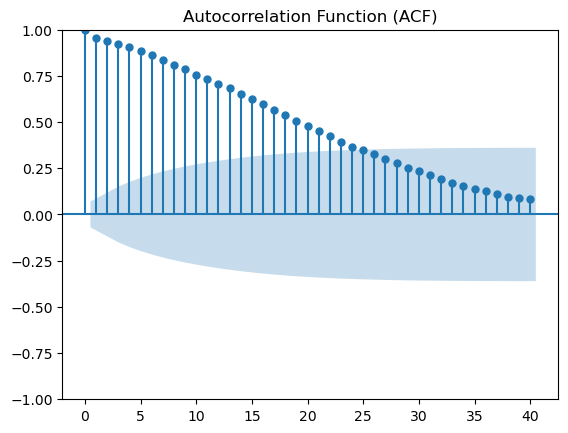

<Figure size 1000x500 with 0 Axes>

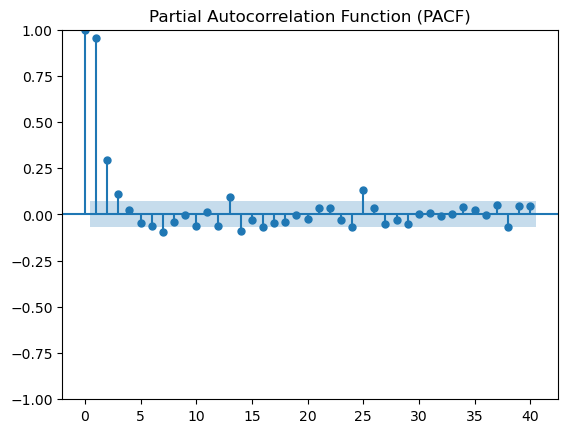

{'messages': [HumanMessage(content='Run the analysis'),
  HumanMessage(content='The results of the Augmented Dickey-Fuller test are as follows:\n\n- Test Statistic: -3.7981\n- p-value: 0.0029\n- Number of Lags: 15\n- Number of Observations: 761\n- Critical Values:\n  - 1%: -3.4389\n  - 5%: -2.8653\n  - 10%: -2.5688\n- AIC: 9204.4705\n\n### Interpretation:\n- The null hypothesis of the Augmented Dickey-Fuller test is that the time series has a unit root, meaning it is non-stationary.\n- Since the p-value (0.0029) is less than the common significance levels (0.01, 0.05, and 0.10), we reject the null hypothesis.\n- Additionally, the test statistic (-3.7981) is less than the critical value at the 1% level (-3.4389), which further supports the conclusion.\n\n### Conclusion:\nThe data is stationary.', name='EDA'),
  HumanMessage(content="The ACF and PACF plots have been generated and saved as 'acf.png' and 'pacf.png', respectively. If you need to view or analyze these plots further, please l

In [13]:
graph.invoke({"messages": [HumanMessage(content="Run the analysis")]})